In [64]:
import networkx as nx

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math

import random as rnd
import math
import os
import glob

from sklearn.datasets.samples_generator import make_swiss_roll
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter 
from sklearn.decomposition import KernelPCA

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from sklearn import manifold, datasets
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import pairwise_distances
from collections import defaultdict
from sklearn.neighbors import NearestNeighbors

from utils import project

### Dataset and parameters for Incremental GSE

In [79]:
folders = glob.glob('???')
f = 'ptb'
t = 'f'
print(f'DATASET: {f}, TAX: {t}')
label = f'{f}_proj_{t}'
dataframe = pd.read_csv(f'./{f}/pivot_{t}_normalized.csv', skipinitialspace=True, sep=';', engine='python')
dataframe = dataframe.drop('Unnamed: 0', axis = 1)
data = dataframe.values

data_proj, pca_proj = project(data)

n_points, MAX_DIM = data_proj.shape

print(f'MAX_DIM: {MAX_DIM}')

DATASET: ptb, TAX: f
MAX_DIM: 36


In [80]:
# n_points = 1500
# data, color = datasets.samples_generator.make_s_curve(n_points, random_state = 3350)
epsilon_1 = 1.0 #for Euclidean epsilon-ball
epsilon_2 = 100.0 #Euclidean kernel parameter
epsilon_3 = 0.5 #Gaussian kernel parameter (for Binet-Cauchy metric)
intrisic_dimension = 30

In [81]:
from sklearn.model_selection import train_test_split
# data_train, data_test, color_train, color_test = train_test_split(data_proj, color, test_size=0.3, random_state = 41)
# data_train, data_test = train_test_split(data_proj, test_size=0.3, random_state = 41)

#UPDATE
data = data_proj

In [82]:
temp = pairwise_distances(data, np.asmatrix(data[100]), metric = 'l2')
a = temp[np.where(temp != 0.0)]
min(a)

0.12360121689856067

In [83]:
k_neighbors = 15

## HERE STARTS CODE. DO NOT CHANGE. JUST RUN ALL BELOW. 

In [84]:
def GetKNearestAndEpsBallIndices(samples, center, k_neighs = 2, eps_1 = 1e-2, metric = 'l2'):
    distances_from_center = pairwise_distances(samples, np.asmatrix(center), metric = 'l2')
    indices_in_ball = np.argwhere(distances_from_center.flatten() < eps_1)
    indices = set(indices_in_ball.flatten())
    nbrs = NearestNeighbors(n_neighbors = k_neighs)
    nbrs.fit(samples)
    dists, neighs_indices = nbrs.kneighbors(np.asmatrix(center))
    indices.update(neighs_indices.flatten())
    return indices

def ComputeManhattanKernel(points, center, eps_2 = 1e-3):
    distances = pairwise_distances(points, np.asmatrix(center), metric = 'l1')
    center_kernels = np.exp(- eps_2 * np.power(distances.flatten(), 2))
    return center_kernels

def GetKNearestNeighbors(samples, center, k_neighs = 20):
    nbrs = NearestNeighbors(n_neighbors= k_neighs)
    nbrs.fit(samples)
    dists, neighs_indices = nbrs.kneighbors(np.asmatrix(center))
    return neighs_indices.flatten()

def GetSampleIndicesInEpsBall(samples, ball_center, eps_1 = 1e-2):
    distances_from_center = euclidean_distances(samples, np.asmatrix(ball_center))
    indices_in_ball = np.argwhere(distances_from_center.flatten() < eps_1)
    return indices_in_ball.flatten()

def ComputeEuclideanKernel(points, center, eps_2 = 1e-3):
    squared_distances = euclidean_distances(points, np.asmatrix(center), squared = True)
    center_kernels = np.exp(- eps_2 * squared_distances.flatten())
    return center_kernels

def ComputeWheightedPCA(weights, points, intrisic_dim_):
    average = np.sum((weights * points.T).T, axis = 0)
    centered_points = points - average
    scaled_centered_points = (np.sqrt(weights) * centered_points.T).T
    v = np.linalg.svd(scaled_centered_points)[2]
    Q_pca = v[:intrisic_dim_, :].transpose()
    assert (scaled_centered_points.shape[0] == points.shape[0]), "Shapes not similar"
    
    return Q_pca

In [85]:
def AddNodesToManifoldGraph(graph, data, points_list, every_point_neighbors, every_point_euclid_kernels):
    for point_index in points_list:
        euclid_neighbors_indices = list(GetKNearestAndEpsBallIndices(data, data[point_index], k_neighbors, epsilon_1, 'l2'))
        #euclid_neighbors_indices = GetKNearestNeighbors(data, data[point_index], k_neighbors)
        #euclid_neighbors_indices = GetSampleIndicesInEpsBall(data, data[point_index], epsilon_1)
        every_point_neighbors[point_index] = euclid_neighbors_indices

        euclid_neighbors = data[euclid_neighbors_indices]

        euclid_kernels = ComputeManhattanKernel(euclid_neighbors, data[point_index], epsilon_2)
        #euclid_kernels = ComputeEuclideanKernel(euclid_neighbors, data[point_index], epsilon_2)
        every_point_euclid_kernels[point_index] = euclid_kernels.tolist()

        #compute weights for every point
        kernels_sum = euclid_kernels.sum()
        point_weights = euclid_kernels / kernels_sum

        Q_pca = ComputeWheightedPCA(point_weights, euclid_neighbors, intrisic_dimension)

        graph.add_node(point_index, Q_PCA = Q_pca)

        print('computed for ' + str(point_index))

In [86]:
def ComputeBinetCauchyKernel(Q_first, Q_second):
    S_first_second = np.dot(Q_first.transpose(), Q_second)
    assert(S_first_second.shape == (intrisic_dimension, intrisic_dimension))
    S_determinant = np.linalg.det(S_first_second)
    bc_kernel = S_determinant**2
    return bc_kernel, S_first_second

def DeleteFromListComputedNeighbor(point_index_, neighbor_index_,
                                   every_point_neighbors, every_point_euclid_kernels):
    if (neighbor_index_ in every_point_neighbors[point_index_]):
        index = every_point_neighbors[point_index_].index(neighbor_index_)
        del every_point_neighbors[point_index_][index]
        del every_point_euclid_kernels[point_index_][index]

def AddEdgesToManifoldGraph(graph, points_list, data, every_point_neighbors, every_point_euclid_kernels):
    for point_index in points_list:
        while(every_point_neighbors[point_index]):
            neighbor_index = every_point_neighbors[point_index].pop()
            euclid_kernel = every_point_euclid_kernels[point_index].pop()
            bc_kernel, S_point_neighbor = ComputeBinetCauchyKernel(graph.nodes[point_index]['Q_PCA'], 
                                                                   graph.nodes[neighbor_index]['Q_PCA'])
                
            aggregate_kernel = euclid_kernel * float(1.0 - bc_kernel < epsilon_3) * bc_kernel
            
            if (aggregate_kernel > 0):
                length = np.linalg.norm(data[point_index] - data[neighbor_index]) / aggregate_kernel
                graph.add_edge(point_index, neighbor_index, weight = length, S_first_second = S_point_neighbor,
                                        kernel = aggregate_kernel)
                graph.add_edge(neighbor_index, point_index, weight = length, S_first_second = S_point_neighbor.T,
                                        kernel = aggregate_kernel)
            #delete from list computed points
            DeleteFromListComputedNeighbor(neighbor_index, point_index,
                                           every_point_neighbors, every_point_euclid_kernels)

In [74]:
from IPython.display import clear_output

In [87]:
# Create graph
manifold_graph = nx.DiGraph()
points_list = range(n_points)
#============================================
every_point_neighbors = {}
every_point_kernels = {} 
#======================================
#Compute for every node Q_pca
AddNodesToManifoldGraph(manifold_graph, data, points_list, every_point_neighbors, every_point_kernels)
clear_output()
print('Nodes are added and its attributes are calculated')

Nodes are added and its attributes are calculated


In [88]:
#compute Aggregate kernel for every neighbor of every point
#construct manifold_graph
AddEdgesToManifoldGraph(manifold_graph, points_list, data, every_point_neighbors, every_point_kernels)
print('Edges are added and its attributes are calculated')
print('Criteria on graph conectivity: ' + str(nx.is_strongly_connected(manifold_graph)))

Edges are added and its attributes are calculated
Criteria on graph conectivity: False


If we got NOT CONNECTED graph, it means that we chose WRONG PARAMETERS

In [90]:
def GetNodesOrder(length_dict):
    order_list = []
    position_list = np.empty(len(length_dict))
    num = 0
    def keyf(x):
        k,v = x
        return (v,k)
    for key, value in sorted(length_dict.items(), key=keyf):
        order_list.append(key)
        position_list[key] = num
        num += 1
    return order_list, position_list

In [93]:
MANIFOLD_GRAPH_ = manifold_graph 

In [95]:
#Compute min eccentricity node and order
all_pairs_shortest_paths = dict(nx.shortest_path_length(manifold_graph.to_undirected(), weight = 'weight'))
eccentricities = nx.eccentricity(manifold_graph.to_undirected(), sp=all_pairs_shortest_paths)
first_node = min(eccentricities, key = eccentricities.get)
#first_node = 1
nodes_order, position_arr = GetNodesOrder(all_pairs_shortest_paths[first_node])

NetworkXError: Found infinite path length because the graph is not connected

In [ ]:
#Compute Manifold Embedding
#Initialization
v_first_node = np.eye(intrisic_dimension)
h_first_node = np.zeros(intrisic_dimension)
manifold_graph.nodes[nodes_order[0]]['v_matrix'] = v_first_node
manifold_graph.nodes[nodes_order[0]]['h_embedding'] = h_first_node

for node in nodes_order[1:]:
    kernel_sum = 0.0
    matrix_sum = np.zeros((intrisic_dimension, intrisic_dimension))
    h_sum = np.zeros(intrisic_dimension)
    x_sum = np.zeros(data.shape[1])
    for neighbor, neigh_dict in manifold_graph[node].items():
        if (position_arr[neighbor] < position_arr[node]):
            kernel = neigh_dict['kernel'] 
            matrix_sum += kernel * neigh_dict['S_first_second'].dot(manifold_graph.nodes[neighbor]['v_matrix'])
            h_sum += kernel * manifold_graph.nodes[neighbor]['h_embedding']
            x_sum += kernel * data[neighbor]
            kernel_sum += kernel

    v_final = matrix_sum / kernel_sum
    h_final = h_sum / kernel_sum + np.linalg.inv(v_final).dot(manifold_graph.nodes[node]['Q_PCA'].T).dot(data[node] - 
              x_sum / kernel_sum)
    manifold_graph.nodes[node]['v_matrix'] = v_final
    manifold_graph.nodes[node]['h_embedding'] = h_final

In [92]:
data_embedding = [manifold_graph.nodes[node]['h_embedding'] for node in range(n_points)]
data_embedding = np.array(data_embedding)

KeyError: 'h_embedding'

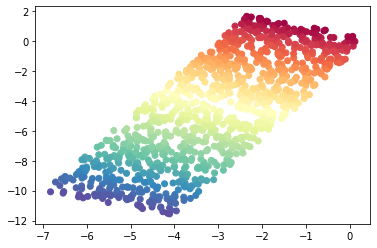

In [50]:
plt.scatter(data_embedding[:, 0], data_embedding[:, 1], c=color, cmap=plt.cm.Spectral)
plt.show()

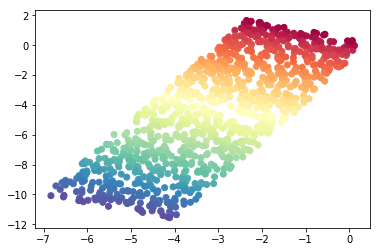

In [108]:
plt.scatter(data_embedding[:, 0], data_embedding[:, 1], c=color, cmap=plt.cm.Spectral)
plt.show()

## Manifold Reconstruction

In [51]:
k_neigh_emb = 3
eps_emb = 0.5

In [52]:
def ComputeBinetCauchyGaussKernel(Q_first, Q_second, eps_3 = 1e1):
    S_first_second = np.dot(Q_first.transpose(), Q_second)
    assert(S_first_second.shape == (intrisic_dimension, intrisic_dimension))
    S_determinant = np.linalg.det(S_first_second)
    bc_kernel = float(1.0 - S_determinant**2 < eps_3) * S_determinant**2
    return bc_kernel, S_first_second

def ReconstructManifold(data_for_reconstruct, data_embedding):
    #Compute for every node y Projector_pca*
    every_point_neigh_indices = {}
    dict_Q_rec_point = {}
    dict_Q_rec_neigh = {}
    #========================================
    unique_neighs_indices = set()

    for point_index in range(data_for_reconstruct.shape[0]):
        neighbors_indices = GetKNearestAndEpsBallIndices(data_embedding, 
                                                         data_for_reconstruct[point_index], 
                                                         k_neigh_emb, eps_emb, 'l2')
        #rec_neighbors_indices = GetKNearestNeighbors(data_embedding, data_embedding[rec_point_index], k_neighs = 20)
        #rec_neighbors_indices = GetSampleIndicesInEpsBall(data_embedding, data_embedding[rec_point_index], epsilon_1 * 0.05)
        every_point_neigh_indices[point_index] = list(neighbors_indices)
        unique_neighs_indices.update(list(neighbors_indices))

        Q_rec = ComputeWheightedPCA(np.ones(len(neighbors_indices)), 
                                    data[list(neighbors_indices)], intrisic_dimension)
        assert(Q_rec.shape[1] == intrisic_dimension), "Q_rec shape error"

        #manifold_graph.node[rec_point_index]['projector'] = Q_rec.dot(Q_rec.transpose())  !!!!! p x p 
        #TODO: change in first implementation
        dict_Q_rec_point[point_index] = Q_rec
        print('neighbors computed for ' + str(point_index))

    #Added function. Compute Q_rec for neighs of points_for_reconstruct
    for neigh_index in unique_neighs_indices:
        neighbors_indices = GetKNearestAndEpsBallIndices(data_embedding, data_embedding[neigh_index],
                                                         k_neigh_emb, eps_emb, 'l2')
        #rec_neighbors_indices = GetKNearestNeighbors(data_embedding, data_embedding[neigh_index], k_neighs = 20)

        Q_rec = ComputeWheightedPCA(np.ones(len(neighbors_indices)),
                                    data[list(neighbors_indices)], intrisic_dimension)
        dict_Q_rec_neigh[neigh_index] = Q_rec
        
    #==================================================================================================================
    #==================================================================================================================
    
    #Compute reconstruction function for each point y in Y_n
    reconstructed_data = []

    ####!!!!! n_points -> points_for_reconstruct
    for point_index in range(data_for_reconstruct.shape[0]):
        kernel_sum = 0.0
        G_matrix_sum = np.zeros((data.shape[1], intrisic_dimension))
        X_sum = np.zeros(data.shape[1])
        y_residuals_sum = np.zeros(intrisic_dimension)

        Q_rec_point = dict_Q_rec_point[point_index]

        neigh_indices = every_point_neigh_indices[point_index]
        print('neighbors computed for ' + str(point_index))
        for neigh_index in neigh_indices:
            neigh_dict = manifold_graph.nodes[neigh_index]
            Q_rec_neigh = dict_Q_rec_neigh[neigh_index]
            kernel, smthing = ComputeBinetCauchyGaussKernel(Q_rec_point, Q_rec_neigh, 2)
            kernel_sum += kernel
            G_matrix_sum += kernel * neigh_dict['Q_PCA'].dot(neigh_dict['v_matrix'])
            #TODO!!!
            X_sum += kernel * data[neigh_index]
            y_residuals_sum += kernel * (data_for_reconstruct[point_index]
                                         - data_embedding[neigh_index])

            
        rec_point_projector = Q_rec_point.dot(Q_rec_point.transpose())
        G_matrix_sum = rec_point_projector.dot(G_matrix_sum) / kernel_sum
        #G_matrix_sum = rec_point_dict['projector'].dot(G_matrix_sum) / rec_kernel_sum
        g_reconstruction = (X_sum - G_matrix_sum.dot(y_residuals_sum)) / kernel_sum
        reconstructed_data.append(g_reconstruction)

    reconstructed_data = np.asarray(reconstructed_data)
    return reconstructed_data

## Test_points

In [53]:
def ComputeEmbeddingForNewNode(graph, train_data, test_point):
    neighbors_indices = list(GetKNearestAndEpsBallIndices(train_data, test_point, k_neighbors, epsilon_1, 'l1'))
     
    kernels = list(ComputeManhattanKernel(train_data[neighbors_indices], test_point, epsilon_2))

    #compute weights for every point
    kernels_sum = sum(kernels)
    point_weights = np.asarray(kernels) / kernels_sum

    Q_pca_test_point = ComputeWheightedPCA(point_weights, train_data[neighbors_indices], intrisic_dimension)
    #====================================================================
    dictionary_of_neighs = {}
    
    while(neighbors_indices):
        neigh_index = neighbors_indices.pop()
        euclid_kernel = kernels.pop()
        bc_kernel, S_point_neighbor = ComputeBinetCauchyGaussKernel(Q_pca_test_point , 
                                                               graph.nodes[neigh_index]['Q_PCA'], 
                                                                epsilon_3)
        aggregate_kernel = euclid_kernel * bc_kernel
        if (aggregate_kernel > 0):
            neigh_dict = {'kernel' : aggregate_kernel, 'S_first_second' : S_point_neighbor}
            dictionary_of_neighs[neigh_index] = neigh_dict
            #graph.add_edge(point_index, neighbor_index, weight = length, 
            #S_first_second = S_point_neighbor, kernel = bc_kernel) TODO!!!!: bc_kernel???????
    
    
    #====================================================================
    kernel_sum = 0.0
    matrix_sum = np.zeros((intrisic_dimension, intrisic_dimension))
    h_sum = np.zeros(intrisic_dimension)
    x_sum = np.zeros(data.shape[1])
    for neigh_index, neigh_dict in dictionary_of_neighs.items():
        kernel = neigh_dict['kernel'] 
        matrix_sum += kernel * neigh_dict['S_first_second'].dot(graph.nodes[neigh_index]['v_matrix'])
        h_sum += kernel * graph.nodes[neigh_index]['h_embedding']
        x_sum += kernel * train_data[neigh_index]
        kernel_sum += kernel

    v_final = matrix_sum / kernel_sum
    h_final = h_sum / kernel_sum + np.linalg.inv(v_final).dot(
                      Q_pca_test_point.T).dot(test_point - x_sum / kernel_sum)
    return np.asarray([h_final])

In [54]:
reconstructed_data = np.asmatrix(np.zeros(data_test.shape[1]))
for index in range(data_test.shape[0]):
    test_point = data_test[index]
#======================================
    h_embedding_test = ComputeEmbeddingForNewNode(manifold_graph, data, test_point)
    reconstructed_point = ReconstructManifold(h_embedding_test, data_embedding)
    reconstructed_data = np.append(reconstructed_data, np.asmatrix(reconstructed_point), axis=0)
clear_output()

In [55]:
reconstructed_data = np.array(reconstructed_data[1 :])

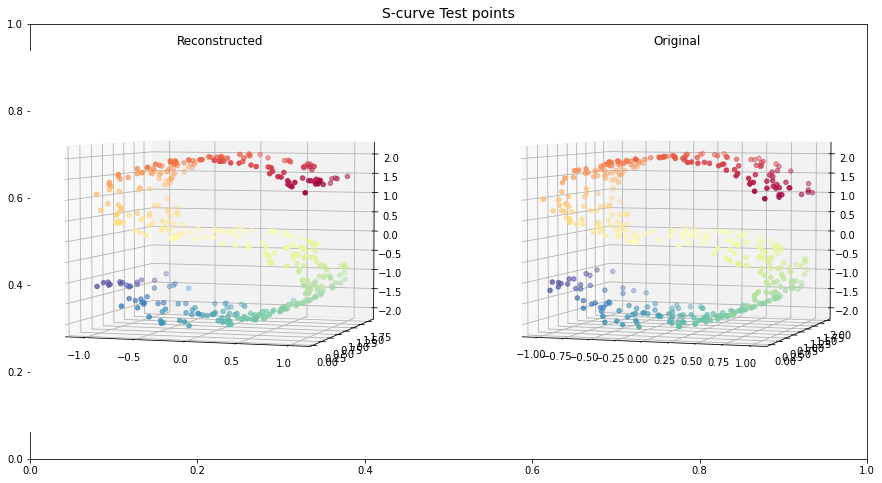

0.061171410591482185


In [57]:
fig = plt.figure(figsize=(15, 8))
plt.title("S-curve Test points", fontsize=14)


# compatibility matplotlib < 1.0
ax = fig.add_subplot(121, projection='3d')
ax.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1],
           reconstructed_data[:, 2], c=color_test, cmap=plt.cm.Spectral)
ax.view_init(4, -72)
plt.title("Reconstructed")

ax = fig.add_subplot(122, projection='3d')
ax.scatter(data_test[:, 0], data_test[:, 1], 
           data_test[:, 2], c=color_test, cmap=plt.cm.Spectral)
ax.view_init(4, -72)
plt.title("Original")

plt.show()
def mae_score(y, y_pred):
    return np.linalg.norm(y_pred - y, axis=1, ord=1).mean() / np.linalg.norm(y, axis=1, ord=1).mean()
print(mae_score(data_test, reconstructed_data))